# Forward Models

---
- 2021-04-25
    - build forward models for each speaker (articulation --> acoustics)
    - See: https://github.com/jaekookang/ucm_gem_analysis/blob/master/procs/IEEE/02_forward_model.ipynb
- 2021-04-25
    - Back to Regular PCA (3D)
- 2021-04-27
    - Test adding F3 and 4 GPCA
- 2021-04-29
    - Add UCM visualization per speaker and vowel

In [1]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

import os
import pickle
import re
import sys
from glob import glob
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image
from sklearn.ensemble import IsolationForest
from tqdm import notebook, tqdm
from pprint import pprint

src_dir = '/home/jkang/project/Articulatory-Data-Processor'
sys.path.append(src_dir)
from tools.utils import *
from tools.plots import *
from tools.postproc import *
from tools.guided_pca import GuidedPCA
from tools.ucm import get_weights, get_ucm_cm, get_score_lr, nullspace

# Differentiation
import numdifftools as nd
from jax import jacfwd, jacrev
import jax.numpy as jnp

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from ruamel.yaml import YAML

rand_seed = 0
flatten = itertools.chain.from_iterable

## Settings

In [2]:
# ----- Options
save_again = False
plot_again = False
use_mel = True
use_guided_pca = True
which_time_points = [0.375, 0.5, 0.625] # a list of time points (mid-point as 0.5 is default)

# ----- Directories
curr_dir = '.'
data_dir = 'data'
save_dir = os.path.join(curr_dir, 'forward_model')
param_dir = os.path.join(curr_dir, 'data_processed')
# data_file = os.path.join(curr_dir, 'data_processed', 'data_2021-04-13.csv')
data_file = os.path.join(curr_dir, 'data_processed', 'data_2021-04-27.csv')

data_files = sorted(glob(os.path.join(data_dir, '[FM]**.txt')))
pal_files = sorted(glob(os.path.join(data_dir, 'palate_*.pkl')))

# ----- Parameters
spkr_list = ['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
# acous_col = ['F1', 'F2']
acous_col = ['F1', 'F2', 'F3']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]

pca_col = ['PC1','PC2','PC3']
gpca_col = ['JAW','LIPS','vTNG','hTNG']
if use_guided_pca:
    num_pca = len(gpca_col)
else:
    num_pca = len(pca_col)

num_points = 9
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']
vowel2ipa = {
    "IY1": "i",
    "IH1": "ɪ",
    "EH1": "ɛ",
    "AO1": "ʌ",
    "AH1": "ɔ",
    "AA1": "ɑ",
    "AE1": "æ",
    "UH1": "ʊ",
    "UW1": "u",
}
num2vowel = {i:v for i, v in enumerate(vowel2ipa.keys())}
vowel2num = {num2vowel[i]:i for i in num2vowel.keys()}

# ----- Plots
xm = 2.5
ym = 2.5
lim = [-0.9, 0.9]

print('Save again:', save_again)
print('Plot again:', plot_again)
print('use gpca:', use_guided_pca)

Save again: False
Plot again: False
use gpca: True


In [3]:
# Make directory for saving plots
if save_again:
    safe_mkdir(os.path.join(save_dir))
    for which_spkr in spkr_list:
        safe_mkdir(os.path.join(save_dir, which_spkr))
    print('Created')
else:
    print('Skipping')

Skipping


## Hyperparameters

- These are for ANN modeling as well as LR.
- Both ar2ac and ac2vw hparams are set. 
    - ac2vw modeling is probably not used.
- For INN, see next notebook.

In [4]:
# ----- AR2AC (template)
hp1 = dict(
    name='ar2ac',
    # --- Data param
    ndim_tot=4,
    ndim_x=4,
    ndim_y=3,
    ndim_z=1,
    # --- Model param
    n_hid_layer=3,
    n_hid_dim=256,
    # --- Train param
    test_split=0.1,
    n_epochs=1000,
    n_display=1,
    n_iter_no_change=50,
)
# ----- AC2VW (template)
hp2 = dict(
    name='ac2vw',
    # --- Data param
    ndim_tot=10,
    ndim_x=2,
    ndim_y=9,
    ndim_z=1,
    # --- Model param
    n_hid_layer=3,
    n_hid_dim=512,
    # --- Train param
    test_split=0.1,
    n_epochs=1000,
    n_display=1,
    n_iter_no_change=100,
)

# ----- Save or Load
hp1_file = os.path.join(save_dir, 'hparams_ar2ac.yaml')
hp2_file = os.path.join(save_dir, 'hparams_ac2vw.yaml')

if save_again:
    # Save hparams
    for _hp_file, _hp in zip([hp1_file, hp2_file], [hp1, hp2]):
        with open(_hp_file, 'w') as f:
            YAML().dump(_hp, f)
        print(f'Saved: {_hp_file}')
    hp1 = HParams(hp1_file)
    hp2 = HParams(hp2_file)
else:
    # Reload already saved file
    hp1 = HParams(hp1_file)
    hp2 = HParams(hp2_file)
    assert hp1.name == 'ar2ac'
    assert hp2.name == 'ac2vw'
    print(f'\nLoaded from saved files: {hp1_file}, {hp2_file}\n')

print('----- AR2AC -----')
pprint(hp1)
print('----- AC2VW -----')
pprint(hp2)


Loaded from saved files: ./forward_model/hparams_ar2ac.yaml, ./forward_model/hparams_ac2vw.yaml

----- AR2AC -----
{'n_display': 1,
 'n_epochs': 1000,
 'n_hid_dim': 256,
 'n_hid_layer': 3,
 'n_iter_no_change': 50,
 'name': 'ar2ac',
 'ndim_tot': 4,
 'ndim_x': 4,
 'ndim_y': 3,
 'ndim_z': 1,
 'test_split': 0.1}
----- AC2VW -----
{'n_display': 1,
 'n_epochs': 1000,
 'n_hid_dim': 512,
 'n_hid_layer': 3,
 'n_iter_no_change': 100,
 'name': 'ac2vw',
 'ndim_tot': 10,
 'ndim_x': 2,
 'ndim_y': 9,
 'ndim_z': 1,
 'test_split': 0.1}


## Prepare data

In [5]:
D = pd.read_csv(data_file)
print(D.shape)
D.head() 
# 2020-10-08: (205200, 61)
# 2020-10-21: (172566, 61) 
# 2020-11-01: (148680, 61)
# 2021-04-25: (138575, 56)

(140305, 59)


,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
0,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.292038,0.089631,-0.164699,0.136676,0.353518,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
1,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.311505,0.089876,-0.163489,0.147812,0.389433,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
2,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.333751,0.089203,-0.161451,0.158579,0.414875,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
3,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.354439,0.082245,-0.159369,0.166227,0.426201,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
4,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.369743,0.065720,-0.155194,0.168594,0.424748,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue


In [6]:
# Get data info
spkr_list = sorted(D.Speaker.unique().tolist())
word_list = sorted(D.Word.unique().tolist())
vowel_list_all = sorted(D.Vowel.unique().tolist())  # all vowels
vowel_list = ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
assert sorted(vowel_list_all) == sorted(vowel_list)
time_list = D.TimeAt.unique().tolist()
block_list = sorted(D.Block.unique().tolist())
print('Speaker:', spkr_list)
print('Unique words: ', len(word_list))
print('Vowels (     all):', vowel_list_all)
print('Vowels (selected):', vowel_list)  # 9 vowels selected
print('Times:', time_list)
print('Blocks:', block_list)

Speaker: ['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
Unique words:  1056
Vowels (     all): ['AA1', 'AE1', 'AH1', 'AO1', 'EH1', 'IH1', 'IY1', 'UH1', 'UW1']
Vowels (selected): ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
Times: [0.0, 0.25, 0.5, 0.75, 1.0]
Blocks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [7]:
# Load palate
pal_all = load_palate(pal_files, spkr_list)
print('Loaded: ', pal_all.keys())

Loaded:  dict_keys(['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04'])


In [8]:
# Load data parameters
with open(os.path.join(param_dir, 'zscore.pkl'), 'rb') as pckl:
    Z = pickle.load(pckl)
if use_guided_pca:
    pca_file = os.path.join(param_dir, 'gpca.pkl')
else:
    pca_file = os.path.join(param_dir, 'pca.pkl')
with open(pca_file, 'rb') as pckl:
    PC = pickle.load(pckl)
VT = pd.read_csv(os.path.join(param_dir, 'vowel_targets.csv'))
GM = pd.read_csv(os.path.join(param_dir, 'grand_means.csv'))
print('Loaded')

Loaded


In [9]:
def calculate_accuracy(y_true, y_pred):
    # y_true: a 1-d array of true labels
    # y_pred: a 1-d array of predicted labels
    assert len(y_true) == len(y_pred)
    correct = sum([1 if y_t == y_p else 0 for y_t, y_p in zip(y_true, y_pred)])
    return correct / len(y_true) * 100

## Train forward models: LR and ANN

In [10]:
def _prepare_data(df, which_spkr, which_rate, vowel_list, Scaler, PC, Z, which_times=[0.5]):
    # NOTE: vowel_list has to be a list eg. ['IY1'] or ['IY1','EH1',...]
    #       time points can be specified by a list of time ticks
    #       default is mid-point only; eg. [0.5]
    assert isinstance(which_times, list), 'Provide a list of time ticks'
    
    # Prepare data
    X_raw = df.loc[((df.Speaker==which_spkr)
                    &(df.Vowel.isin(vowel_list))
                    &(df.TimeAt.isin(which_times))
                    &(df.Rate==which_rate)), ['Vowel']+artic_col]
    Y_raw = df.loc[((df.Speaker==which_spkr)
                    &(df.Vowel.isin(vowel_list))
                    &(df.TimeAt.isin(which_times))
                    &(df.Rate==which_rate)), acous_col]
    pal = pal_all[which_spkr]

    # Prepare parameters
    scaler = Scaler(which_spkr, Z)
    if use_guided_pca:
        pca = PC[which_spkr]['gpca']
    else:
        pca = PC[which_spkr]['pca']

    # Transform data
    X = scaler.transform(X_raw[artic_col].values, 'artic')
    X = pca.transform(X)                    # (N,5)
    Y = scaler.transform(Y_raw.values, 'acous')    # (N,3)
    
    # Make labels
    V = X_raw.Vowel.values
    V = [vowel2num[v] for v in V]
    V = np.eye(len(vowel_list))[V]
    return X, Y, V

def _LinearRegression(x_train, y_train, x_test, y_test):
    # Get LR weights and UCM/CM vectors
    weights, train_score = get_weights(x_train, y_train, show_score=True)
    test_score = get_score_lr(weights, x_test, y_test)
    #ucm_vec, cm_vec = get_ucm_cm(weights)
    lr_model = lambda x: x.dot(weights)
    train_rmse = mean_squared_error(y_train, lr_model(x_train), squared=False)
    test_rmse = mean_squared_error(y_test, lr_model(x_test), squared=False)
    return dict(
        weights=weights,
        #ucm_vec=ucm_vec,
        #cm_vec=cm_vec,
        train_score=train_score,
        test_score=test_score,
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        model_as_string="lambda x: x.dot(weights)"
    )

def _ANN(x_train, y_train, x_test, y_test, n_hid_dim, n_hid_layer, n_epochs, n_iter_no_change=50, rnd_seed=None):
    # Get ANN weights and UCM/CM vectors
    ann_model = MLPRegressor(
        hidden_layer_sizes=[n_hid_dim]*n_hid_layer,
        activation='relu',
        learning_rate='adaptive',
        random_state=rnd_seed,
        early_stopping=True,
        n_iter_no_change=n_iter_no_change,
        validation_fraction=0.1,
        max_iter=n_epochs)
    ann_model.fit(x_train, y_train)
    
    train_score = ann_model.score(x_train, y_train)
    test_score = ann_model.score(x_test, y_test)
    train_rmse = mean_squared_error(y_train, ann_model.predict(x_train), squared=False) # squared=False --> returns RMSE
    test_rmse = mean_squared_error(y_test, ann_model.predict(x_test), squared=False)    # squared=False --> returns RMSE
    
    def forward(X):
        # X: (n, dim)
        Weights = ann_model.coefs_
        biases = ann_model.intercepts_

        h = X
        for i in range(len(Weights)-1):
            h = h.dot(Weights[i]) + biases[i]
            h = np.maximum(h, 0)
        y = h.dot(Weights[-1]) + biases[-1]
        return y  # Nx2
    
    # Jacobian for ANN
    #vdata = np.median(x_train, axis=0) # compute at vowel artic median
    #jacob = nd.Jacobian(forward)
    #J = jacob(vdata)
    #ucm_vec, cm_vec = nullspace(J, rangespace=True)
    
    return dict(
        model=ann_model,
        #ucm_vec=ucm_vec,
        #cm_vec=cm_vec,
        train_score=train_score,
        test_score=test_score,
        train_rmse=train_rmse,
        test_rmse=test_rmse,
    )

In [11]:
# Train forward models
per_vowel_modeling = False

if save_again:
    # Iterate over speakers
    for i, which_spkr in tqdm(enumerate(spkr_list), total=len(spkr_list)):

        # ----- Modeling using all data
        # Prepare data
        #X, Y = _prepare_data(D, which_spkr, vowel_list, Scaler, PC, Z, which_times=which_time_points)
        X_N, Y_N, V_N = _prepare_data(D, which_spkr, 'N', vowel_list, Scaler, PC, Z, which_times=which_time_points)
        X_F, Y_F, V_F = _prepare_data(D, which_spkr, 'F', vowel_list, Scaler, PC, Z, which_times=which_time_points)
        V_N_idx = np.argmax(V_N, axis=1)
        V_F_idx = np.argmax(V_F, axis=1)

        # Divide train/test
        x_train_N, x_test_N, y_train_N, y_test_N, train_N_idx, test_N_idx = train_test_split(X_N, Y_N, V_N_idx, test_size=hp1.test_split, random_state=rand_seed)
        x_train_F, x_test_F, y_train_F, y_test_F, train_F_idx, test_F_idx = train_test_split(X_F, Y_F, V_F_idx, test_size=hp1.test_split, random_state=rand_seed)
        
        x_train = np.vstack([x_train_N, x_train_F])
        x_test = np.vstack([x_test_N, x_test_F])
        y_train = np.vstack([y_train_N, y_train_F])
        y_test = np.vstack([y_test_N, y_test_F])
        
        v_train_N = np.eye(len(vowel_list))[train_N_idx]
        v_train_F = np.eye(len(vowel_list))[train_F_idx]
        v_test_N = np.eye(len(vowel_list))[test_N_idx]
        v_test_F = np.eye(len(vowel_list))[test_F_idx]
        v_train = np.vstack([v_train_N, v_train_F])
        v_test = np.vstack([v_test_N, v_test_F])
        
        # Linear Regression
        dict_lr = _LinearRegression(x_train, y_train, x_test, y_test)
        #LR['all'] = dict_lr
            
        # ANN
        dict_ann = _ANN(x_train, y_train, x_test, y_test, hp1.n_hid_dim, hp1.n_hid_layer, hp1.n_epochs, n_iter_no_change=hp1.n_iter_no_change, rnd_seed=rand_seed)
        #ANN['all'] = dict_ann

        if per_vowel_modeling:
            # ----- Modeling per vowel
            for j, which_vowel in enumerate(vowel_list):
                X, Y = _prepare_data(D, which_spkr, [which_vowel], Scaler, PC, Z)
                x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=hp1.test_split, random_state=rand_seed)
                # LR
                dict_lr = _LinearRegression(x_train, y_train, x_test, y_test)
                LR[which_vowel] = dict_lr
                # ANN
                dict_ann = _ANN(x_train, y_train, x_test, y_test, hp1.n_hid_dim, hp1.n_hid_layer, hp1.n_epochs, rnd_seed=rand_seed)
                ANN[which_vowel] = dict_ann
        
        # ----- Save models & data
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'train_data.npz'), x=x_train, y=y_train)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'train_data_N.npz'), x=x_train_N, y=y_train_N)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'train_data_F.npz'), x=x_train_F, y=y_train_F)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'test_data.npz'), x=x_test, y=y_test)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'test_data_N.npz'), x=x_test_N, y=y_test_N)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'test_data_F.npz'), x=x_test_F, y=y_test_F)

        np.savez_compressed(os.path.join(save_dir, which_spkr, 'train_label.npz'), v=v_train)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'test_label.npz'), v=v_test)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'train_label_N.npz'), v=v_train_N)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'test_label_N.npz'), v=v_test_N)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'train_label_F.npz'), v=v_train_F)
        np.savez_compressed(os.path.join(save_dir, which_spkr, 'test_label_F.npz'), v=v_test_F)
                
        with open(os.path.join(save_dir, which_spkr, 'model_linear.pckl'), 'wb') as pckl:
            pickle.dump(dict_lr, pckl)
        with open(os.path.join(save_dir, which_spkr, 'model_ann.pckl'), 'wb') as pckl:
            pickle.dump(dict_ann, pckl)
            
    print('Trained/Saved')
else:
    print('Skipping')

Skipping


### Validate LR and ANN models


In [12]:
def _load_model_params(save_dir, which_spkr):
    with open(os.path.join(save_dir, which_spkr, 'model_linear.pckl'), 'rb') as pckl:
        LR = pickle.load(pckl)
        weights = LR['weights']
        lr_model = lambda x: x.dot(weights)

    with open(os.path.join(save_dir, which_spkr, 'model_ann.pckl'), 'rb') as pckl:
        ANN = pickle.load(pckl)
        ann_model = ANN['model'].predict
        
    with open(os.path.join(save_dir, which_spkr, 'ucm_cm.pckl'), 'rb') as pckl:
        UCM = pickle.load(pckl)

    # Prepare palate
    pal = pal_all[which_spkr]

    # Initiate
    scaler = Scaler(which_spkr, Z)
    if use_guided_pca:
        pca = PC[which_spkr]['gpca']
    else:
        pca = PC[which_spkr]['pca']
    return LR, ANN, lr_model, ann_model, pal, scaler, pca, UCM

LR, ANN, _, _, _, _, _, _ = _load_model_params(save_dir, 'F01')
LR, ANN

({'weights': array([[ 0.42781094, -0.42209273, -0.9019086 ],
         [ 0.19249593,  1.15784195,  0.48087101],
         [ 0.50741325, -0.69571891,  0.33150152],
         [-0.00315558, -0.7406599 , -0.45244725]]),
  'train_score': 0.6121043603592867,
  'test_score': 0.5845776352424786,
  'train_rmse': 0.40029404562724463,
  'test_rmse': 0.41166632203162523,
  'model_as_string': 'lambda x: x.dot(weights)'},
 {'model': MLPRegressor(early_stopping=True, hidden_layer_sizes=[256, 256, 256],
               learning_rate='adaptive', max_iter=1000, n_iter_no_change=50,
               random_state=0),
  'train_score': 0.8081286711348827,
  'test_score': 0.7549172102316658,
  'train_rmse': 0.25478210847083843,
  'test_rmse': 0.28440225013496295})

### Plot model train/test error

In [13]:
# Make dataframe
Speaker = []
Model = []
Data = []
Type = []
Score = []
RMSE = []
for which_spkr in spkr_list:
    LR, ANN, _, _, _, _, _, _, = _load_model_params(save_dir, which_spkr)
    
    Score.append(LR['train_score'])
    Score.append(LR['test_score'])
    Score.append(ANN['train_score'])
    Score.append(ANN['test_score'])
    RMSE.append(LR['train_rmse'])
    RMSE.append(LR['test_rmse'])
    RMSE.append(ANN['train_rmse'])
    RMSE.append(ANN['test_rmse'])
    Speaker += [which_spkr]*4
    Model += ['LR','LR','ANN','ANN']
    Data += ['Train', 'Test']*2
ER = pd.DataFrame({
    'Speaker':Speaker,
    'Model':Model,
    'Data':Data,
    'Score':Score,
    'RMSE':RMSE
})

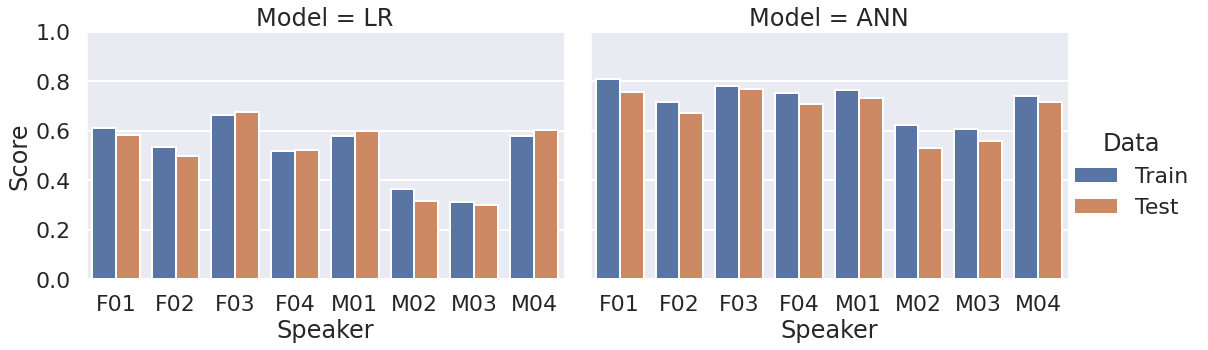

In [14]:
# Plot Score
with sns.plotting_context('poster'):
    g = sns.catplot(x='Speaker',y='Score',hue='Data', data=ER,
                    col='Model', kind='bar', height=5, aspect=1.5)
    g.fig.set_facecolor('white')
    g.set(ylim=[0, 1])

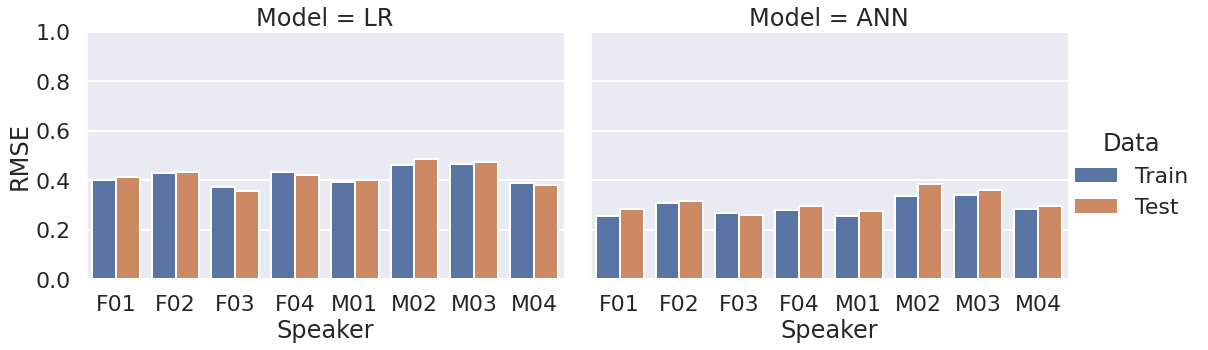

In [15]:
# Plot RMSE
with sns.plotting_context('poster'):
    g = sns.catplot(x='Speaker',y='RMSE',hue='Data', data=ER,
                    col='Model', kind='bar', height=5, aspect=1.5)
    g.fig.set_facecolor('white')
    g.set(ylim=[0, 1])

### Add UCM, CM vectors

In [13]:
def predict(X, W, b):
    # X: (n, dim)
    # W = ann_model.coefs_
    # b = ann_model.intercepts_
    W = [jnp.array(wi) for wi in W]
    b = [jnp.array(bi) for bi in b]
    h = jnp.array(X)
    for i in range(len(W)-1):
        h = h.dot(W[i]) + b[i]
        h = jnp.maximum(h, 0)
    y = h.dot(W[-1]) + b[-1]
    return y  # Nx2

## UCM, CM양 비교

In [14]:
base_on_N = True

if save_again:
    # Compute UCM and CM per speaker, vowel and time
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):

        # Load params
        LR, ANN, lr_model, _, pal, scaler, pca, _ = _load_model_params(save_dir, which_spkr)
        ann_model = ANN['model']
        UCM = {}

        for which_vowel in vowel_list:
            UCM[which_vowel] = {}

            for which_time in time_list:
                UCM[which_vowel][which_time] = {'LR':{}, 'ANN':{}, 'based_on_N':base_on_N}
                
                if base_on_N:
                    # Base on 'N' rate data only
                    d = D.loc[(D.Speaker==which_spkr)&(D.Vowel==which_vowel)&(D.TimeAt==which_time)&(D.Rate=='N'), artic_col].values
                
                else:
                    # Both 'N' and 'F' data
                    #d = D.loc[(D.Speaker==which_spkr)&(D.Vowel==which_vowel)&(D.TimeAt==which_time), artic_col].values
                    d = VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel==which_vowel)&(D.TimeAt==which_time), artic_col].values
                
                d = scaler.transform(d, 'artic')
                d = pca.transform(d)
                mean = d.mean(axis=0)

                # --- LR
                ucm_vec, cm_vec = get_ucm_cm(LR['weights'])
                ucm_vec = ucm_vec/np.linalg.norm(ucm_vec)
                UCM[which_vowel][which_time]['LR'].update({
                    'ucm_vec': ucm_vec,
                    'cm_vec' : cm_vec,
                })

                # --- ANN
                #jacob = nd.Jacobian(forward)
                #J = jacob(mean)
                ann_model = ANN['model']
                W = ann_model.coefs_
                b = ann_model.intercepts_
                f = lambda X: predict(X, W, b)
                J = jacfwd(f)(mean)
                J = np.array(J)
                ucm_vec, cm_vec = nullspace(J, rangespace=True)
                UCM[which_vowel][which_time]['ANN'].update({
                    'ucm_vec': ucm_vec,
                    'cm_vec' : cm_vec,
                })
        # Save per speaker
        with open(os.path.join(save_dir, which_spkr, 'ucm_cm.pckl'), 'wb') as pckl:
            pickle.dump(UCM, pckl)
else:
    # Load
    with open(os.path.join(save_dir, which_spkr, 'ucm_cm.pckl'), 'rb') as pckl:
        UCM = pickle.load(pckl)
    print('Skipping')

NameError: name 'which_spkr' is not defined

### Visualize LR and ANN model

interactive(children=(Dropdown(description='model_type', index=1, options=('LR', 'ANN'), value='ANN'), Dropdow…

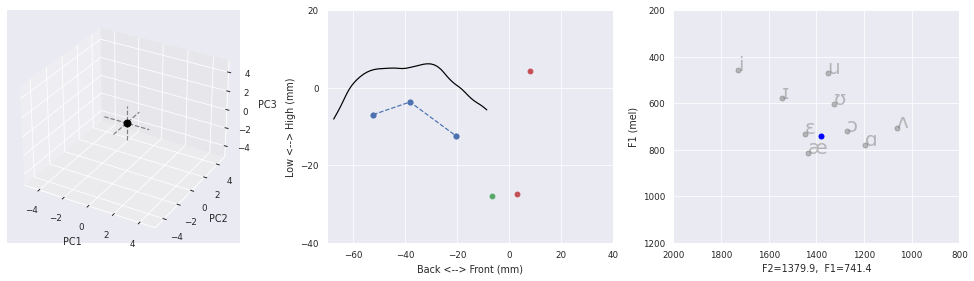

In [13]:
# Validate data
sns.set_theme(context='paper')
which_time = 0.5
def pca_forward_plot(model_type, which_spkr, pc1, pc2, pc3, 
                     pc4 # for GPCA
                    ):
    '''Plot forward mapping from PCs'''
    num_vis_pc = 3 # There are 4 PCs, but plot only 3 PCs
    lim_coef = 2
    LR, ANN, lr_model, ann_model, pal, scaler, pca, _ = _load_model_params(save_dir, which_spkr)

    if model_type=='LR':
        model = lr_model
    elif model_type=='ANN':
        model = ann_model
    median = (VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel.isin(vowel_list))&(VT.TimeAt==which_time)]
              .sort_values(by='Vowel', key=lambda col: [vowel_list.index(v) for v in col.values])[acous_col]
              .values)
    
    fig = plt.figure(facecolor='white', figsize=(14, 4))
    fig.set_facecolor('white')
    
    # PCA space
    ax1 = fig.add_subplot(131, projection='3d')
    lm = [l*lim_coef for l in lim]
    ax1.plot([lm[0],lm[1]],[0,0],[0,0],'--', color='gray', zorder=0)
    ax1.plot([0,0],[lm[0],lm[1]],[0,0],'--', color='gray', zorder=0)
    ax1.plot([0,0],[0,0],[lm[0],lm[1]],'--', color='gray', zorder=0)
    ax1.scatter(pc1, pc2, pc3, c='black', s=50, zorder=10)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax1.set_xlim([-5, 5])
    ax1.set_ylim([-5, 5])
    ax1.set_zlim([-5, 5])    
    ax1.set_aspect('auto')
    
    # Articulator space
    # Get data
    x_z_pca = np.array([[pc1, pc2, pc3, 
                         pc4  # GPCA
                        ]])
    x_z = pca.inverse_transform(x_z_pca)
    x = scaler.inverse_transform(x_z, 'artic').squeeze()

    # Artic space
    ax1 = fig.add_subplot(132)
    ax1 = plot_palpha(ax1, pal=pal, pha=None)
    ax1 = plot_artic(ax1, x, list(range(6)), list(range(6,8)), list(range(8,12)), 
                     tongue_spline=False)
    ax1.set_ylim([-40, 20])
    
    # F1-F2 space
    # Estimate F1, F2, F3
    y_z = model(x_z_pca)
    y = scaler.inverse_transform(y_z, 'acous').squeeze()

    if len(acous_col) == 3:
        F1, F2, F3 = y
    else:
        F1, F2 = y
    
    ax2 = fig.add_subplot(133)
    ax2 = plot_F1F2_ref(ax2, median[:,0], median[:,1], [vowel2ipa[v] for v in vowel_list], use_mel=use_mel)
    ax2 = plot_F1F2(ax2, F1, F2, use_mel=use_mel, markersize=5, color='blue')
    fig.tight_layout()

# pca_forward_plot('ANN','F01',0,0,0)
pca_forward_plot('ANN','F01',0,0,0,0)

model_dropdown = widgets.Dropdown(options=['LR','ANN'], value='ANN')
spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
interactive_plot1 = interactive(pca_forward_plot, 
                                model_type=model_dropdown,
                                which_spkr=spkr_dropdown,
                                pc1=(lim[0],lim[1],0.1), 
                                pc2=(lim[0],lim[1],0.1),
                                pc3=(lim[0],lim[1],0.1),
                                pc4=(lim[0],lim[1],0.1),  # for GPCA
                                continuous_update=True)
output = interactive_plot1.children[-1]
interactive_plot1

In [14]:
# Prepare data
lim = [-0.6, 0.6] # synthesis range
# pca_col = ['PC1','PC2','PC3','PC4']
# pca_col = ['PC1','PC2','PC3']
npc = len(gpca_col)
nsample = 5
samples = np.round_(np.linspace(lim[0], lim[1], nsample), decimals=2)
data = np.zeros((nsample*npc, npc))
data[nsample*0:nsample*1,0] = samples
data[nsample*1:nsample*2,1] = samples
data[nsample*2:nsample*3,2] = samples
data[nsample*3:nsample*4,3] = samples

Speaker = []
PC_col = []
SD_col = []
artic_data = np.zeros((len(spkr_list)*npc*nsample, len(artic_col)))
acous_data = np.zeros((len(spkr_list)*npc*nsample, len(acous_col)))

# Iterate over speakers
for i, which_spkr in tqdm(enumerate(spkr_list), total=len(spkr_list)):
    with open(os.path.join(save_dir, which_spkr, 'model_ann.pckl'), 'rb') as pckl:
        ANN = pickle.load(pckl)
        ann_model = ANN['model'].predict
    scaler = Scaler(which_spkr, Z)
    if use_guided_pca:
        pca = PC[which_spkr]['gpca']
    else:
        pca = PC[which_spkr]['pca']
    pal = pal_all[which_spkr]
    xdata = pca.inverse_transform(data)
    xdata = scaler.inverse_transform(xdata, 'artic')
    ydata = ann_model(data)
    ydata = scaler.inverse_transform(ydata, 'acous')
    
    Speaker += [which_spkr]*npc*nsample
    if use_guided_pca:
        PC_col += sorted(gpca_col*nsample)
    else:
        PC_col += sorted(pca_col*nsample)
    SD_col += samples.tolist()*npc
    artic_data[npc*nsample*i:npc*nsample*(i+1),:] = xdata
    acous_data[npc*nsample*i:npc*nsample*(i+1),:] = ydata

PD = pd.DataFrame({
    'Speaker':Speaker,
    'PCA':PC_col,
    'SD':SD_col,
})
PD[artic_col] = pd.DataFrame(artic_data)
PD[acous_col] = pd.DataFrame(acous_data)
PD.head()

100%|██████████| 8/8 [00:00<00:00, 675.45it/s]


,Speaker,PCA,SD,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz,F1_mel,F2_mel,F3_mel
0,F01,JAW,-0.6,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-3.222447,-20.688875,7.930368,4.257818,3.004001,-27.402126,674.005062,1344.240684,1875.790162
1,F01,JAW,-0.3,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-4.850504,-24.302069,7.930368,4.257818,3.004001,-27.402126,703.605360,1368.071327,1855.896749
2,F01,JAW,0.0,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-6.478561,-27.915262,7.930368,4.257818,3.004001,-27.402126,741.386329,1379.903960,1822.970802
3,F01,JAW,0.3,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-8.106618,-31.528456,7.930368,4.257818,3.004001,-27.402126,802.703993,1335.106949,1756.319818
4,F01,JAW,0.6,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-9.734675,-35.141650,7.930368,4.257818,3.004001,-27.402126,827.777575,1261.311893,1673.181026


In [15]:
colors = ['b', 'r', 'g','m']
which_spkr = 'F01'
pal = pal_all[which_spkr]
which_time = 0.5
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)

# Iterate over speakers
if plot_again:
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
        median = (VT.loc[(VT.Speaker == which_spkr) & (VT.Vowel.isin(vowel_list)) & (VT.TimeAt==which_time)]
                  .sort_values(by='Vowel', key=lambda col: [vowel_list.index(v) for v in col.values])[acous_col]
                  .values)
        fig, arr = plt.subplots(2, npc, facecolor='white', figsize=(17, 8))
        # Iterate over PC
        for i, which_pc in enumerate(gpca_col):
            arr[0, i] = plot_palpha(arr[0, i], pal=pal)
            lines1 = []
            lines2 = []
            # Iterate over SD
            for j, which_sd in enumerate(samples):
                d = PD.loc[(PD.Speaker == which_spkr) & (PD.PCA == which_pc) & (PD.SD == which_sd)]
                F1 = d[acous_col].values[:,0]
                F2 = d[acous_col].values[:,1]
                # --- Articulation
                ax = arr[0, i]
                ax = plot_artic(ax, d[artic_col].values,
                                tongue_idx=[0, 1, 2, 3, 4, 5], jaw_idx=[6, 7], lip_idx=[8, 9, 10, 11],
                                tongue_spline=True, markersize=(j+3)*1.3,
                                override_color=[colors[i]]*3,
                                markerfacecolor='none')
                lines1 += [ax.get_lines()[-1]]

                # --- Acoustics
                ax = arr[1, i]
                ax = plot_F1F2_ref(ax, median[:, 0], median[:, 1], [vowel2ipa[v] for v in vowel_list], 
                                   textcolor='lightgray', use_mel=use_mel)
                ax = plot_F1F2(ax, F1, F2, use_mel=use_mel, markersize=(j+3)*1.3, color=colors[i])
                lines2 += [ax.get_lines()[-1]]
                fig.tight_layout()
            arr[0, i].legend(lines1, samples)
            arr[1, i].legend(lines2, samples)
        # Save
        if save_again:
            pca_grad_dir = os.path.join(save_dir, which_spkr, 'gpca')
            safe_mkdir(pca_grad_dir)
            fig.savefig(os.path.join(pca_grad_dir, f'{which_spkr}_pca_gradient.png'))
        plt.close()
else:
    print('skipping')

skipping


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

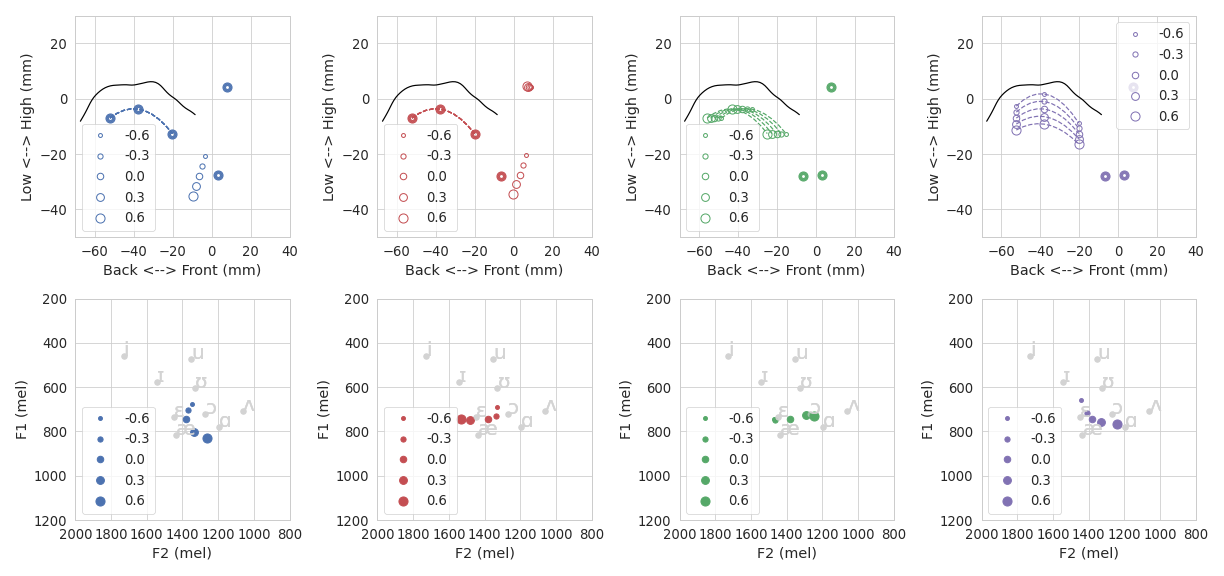

In [21]:
def func(which_spkr):
    return Image(filename=os.path.join(save_dir, which_spkr, 'gpca', f'{which_spkr}_pca_gradient.png'), width=1000)

spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
interact(func, which_spkr=spkr_dropdown);
func('F01')

## Explore UCM space

### Validate UCM by Linear Regression

In [128]:
sns.set_theme(style='darkgrid')
def _prep_data_for_ucm(model_dir, model_type, which_spkr, which_vowel, which_rate, which_time, 
                       lim=[-0.5,0.5], nsample=5, use_median=False):
    # Prepare params
    LR, ANN, lr_model, ann_model, pal, scaler, pca, UCM = _load_model_params(model_dir, which_spkr)

    # Prepare original data
    if which_rate == 'NF':
        which_rate = ['N', 'F']
    else:
        which_rate = [which_rate]
    cond = ((D.Speaker==which_spkr)&
            (D.Vowel==which_vowel)&
            (D.TimeAt==which_time)&
            (D.Rate.isin(which_rate)))
    formants = D.loc[cond, acous_col].values
    artics = D.loc[cond, artic_col].values
    artics = scaler.transform(artics, 'artic')
    artics = pca.transform(artics).squeeze()
    
    median = (VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel.isin(vowel_list))&(VT.TimeAt==which_time)]
              .sort_values(by='Vowel', key=lambda col: [vowel_list.index(v) for v in col.values])[acous_col]
              .values) # acous median

    # Get vowel-median artic data 
    #vdata = VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel==which_vowel), artic_col].values
    if use_median:
        vdata = D.loc[cond, artic_col].median(axis=0).values[np.newaxis,:]
    else:
        vdata = D.loc[cond, artic_col].mean(axis=0).values[np.newaxis,:]
    vdata = scaler.transform(vdata, 'artic')
    vdata = pca.transform(vdata).squeeze()
    init_pcs = vdata

    # Prepare models
    if model_type=='LR':
        ucm_vec = UCM[which_vowel][which_time]['LR']['ucm_vec']
        cm_vec = UCM[which_vowel][which_time]['LR']['cm_vec']
        #ucm_vec = LR[which_model]['ucm_vec']
        #cm_vec = LR[which_model]['cm_vec']
        #model = lambda X: X.dot(LR[which_model]['weights'])
        model = lambda X: X.dot(LR['weights'])
    elif model_type=='ANN':
        ucm_vec = UCM[which_vowel][which_time]['ANN']['ucm_vec']
        cm_vec = UCM[which_vowel][which_time]['ANN']['cm_vec']
        #ucm_vec = ANN[which_model]['ucm_vec']
        #cm_vec = ANN[which_model]['cm_vec']
        #model = ANN[which_model]['model'].predict
        model = ANN['model'].predict

    # Make 1-d UCM line
    d = [(init_pcs+ucm_vec.T*i).tolist()[0] for i in np.linspace(lim[0], lim[1], nsample)]
    d = np.array(d)
    return model, init_pcs, ucm_vec, cm_vec, d, median, pal, scaler, pca, artics, formants


def ucm_plot(model_type, which_spkr, which_vowel, which_rate, which_time, ucm1):
    use_mel=True
    # Prepare data
    # model, init_pcs, ucm_vec, cm_vec, d, median, pal, scaler, pca, artics, formants
    model, init_pcs, ucm_vec, cm_vec, d, median, pal, scaler, pca, artics, formants = _prep_data_for_ucm(
        save_dir, model_type, which_spkr, which_vowel, which_rate, which_time, lim=[-4,4])
    
    #ucm_mat = np.array([[ucm1, ucm2]])
    #pc1, pc2, pc3, pc4 = (init_pcs + ucm_mat.dot(ucm_vec.T)).squeeze()
    #pc1, pc2, pc3 = (init_pcs + ucm_vec.T * ucm1).squeeze()
    pc1, pc2, pc3, pc4 = (init_pcs + ucm_vec.T * ucm1).squeeze()
    
    fig = plt.figure(figsize=(18,15),facecolor='white')
    sns.set_theme(context='poster', style='whitegrid', font_scale=0.8)
    
    # Make CM ellipse
    xd, yd, zd = make_ellipsoid(cm_vec[:3, :], r=lim[0]*0.5)
    xd += init_pcs[0]
    yd += init_pcs[1]
    zd += init_pcs[2]
    
    # PCA space
    ax1 = fig.add_subplot(221, projection='3d')
    
    ax1.plot_wireframe(xd, yd, zd, rstride=3, cstride=3, color='gray', alpha=0.05, zorder=1) # cm ellipse
    ax1.plot(d[:,0],d[:,1],d[:,2],'--', linewidth=1, color='blue', zorder=3) # ucm line
    ax1.plot(artics[:,0],artics[:,1],artics[:,2],'o', color='black', markersize=2, alpha=0.8, zorder=2) # original data
    ax1.scatter(pc1, pc2, pc3, c='blue', s=60, zorder=10)

    ax1.set_xlabel('PC1', fontsize=20, labelpad=20)
    ax1.set_ylabel('PC2', fontsize=20, labelpad=20)
    ax1.set_zlabel('PC3', fontsize=20, labelpad=20)
    ax1.set_title('PCA space', fontsize=40, y=1.2)
#     ax1.set_xlabel('JAW', labelpad=14)
#     ax1.set_ylabel('LIPS', labelpad=16)
#     ax1.set_zlabel('vTNG', labelpad=16)
    
    lm = [-2, 2]
    #ax1.set_xlim(lm)
    #ax1.set_ylim(lm)
    #ax1.set_zlim(lm) 
#     ax1.set_xlim([-0.16, 0.16])
#     ax1.set_ylim([-0.31, 0.31])
#     ax1.set_zlim([-2.9, 2.9])
    
    # Articulatory space
    x_in = np.array([[pc1, pc2, pc3, 
                      pc4 # for GPCA
                     ]])
    x = pca.inverse_transform(x_in)
    x = scaler.inverse_transform(x, 'artic').squeeze()
    
    ax2 = fig.add_subplot(223)
    ax2 = plot_palpha(ax2, pal=pal, pha=None)
    ax2 = plot_artic(ax2, x, tongue_idx=[0,1,2,3,4,5], jaw_idx=[6,7], lip_idx=[8,9,10,11],
                     tongue_spline=False)
    ax2.set_xlabel('Posterior ⟷ Frontal (mm)', fontsize=25)
    ax2.set_ylabel('Inferior ⟷ Superior (mm)', fontsize=25)
    ax2.set_title('Articualtory space', fontsize=40, y=1.1)
    
    # Acoustic space
    y = model(x_in)
    y = scaler.inverse_transform(y, 'acous').squeeze()
    if use_guided_pca:
        F1, F2, F3 = y
    else:
        F1, F2 = y
    F1_all, F2_all = formants[:,0], formants[:,1]
    
    ax3 = fig.add_subplot(224)
    ax3 = plot_F1F2_ref(ax3, median[:,0], median[:,1], [vowel2ipa[v] for v in vowel_list], use_mel=use_mel)
    ax3 = plot_F1F2(ax3, F1_all, F2_all, markersize=1, color='lightblue', alpha=0.5, use_mel=use_mel)
    ax3 = plot_F1F2(ax3, F1, F2, color='blue', use_mel=use_mel)
    
    ax3.set_title('Acoustic space', fontsize=40, y=1.1)
    ax3.set_xlabel('F2 (mel)', fontsize=25)
    ax3.set_ylabel('F1 (mel)', fontsize=25)
    
    plt.suptitle(f'{which_spkr} {which_vowel}', fontsize=30, 
                 #y=1.02
                )
    fig.tight_layout(pad=2.1)

interactive(children=(Dropdown(description='model_type', index=1, options=('LR', 'ANN'), value='ANN'), Dropdow…

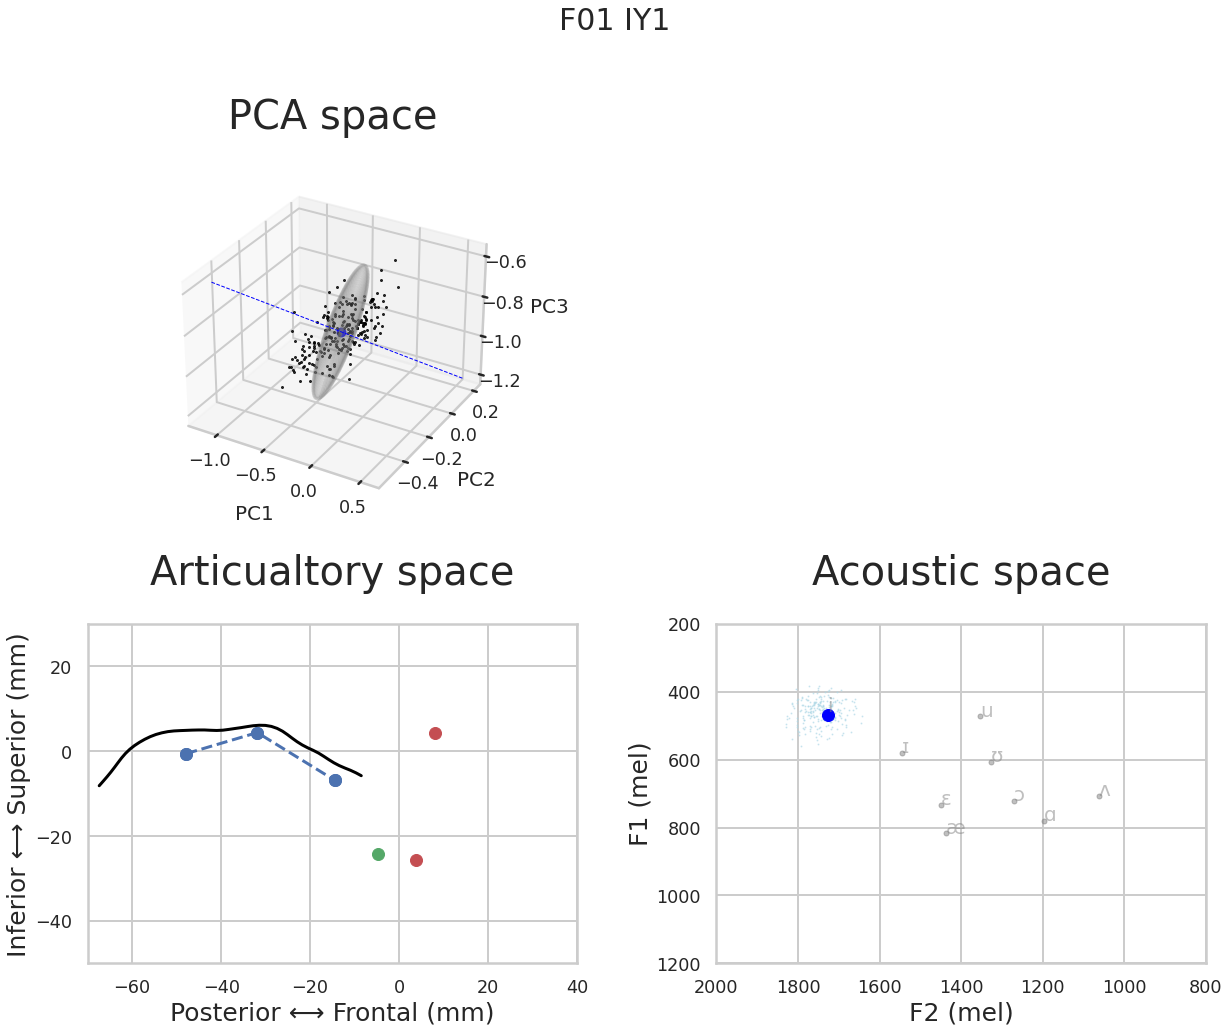

In [129]:
model_dropdown = widgets.Dropdown(options=['LR','ANN'], value='ANN')
spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
vowel_dropdown = widgets.Dropdown(options=vowel_list, value='IY1')
rate_dropdown = widgets.Dropdown(options=['N','F','NF'], value='NF')
time_dropdown = widgets.Dropdown(options=time_list, value=0.5)

ucm_plot('ANN', 'F01', 'IY1', 'N', 0.5, 0)
interactive_plot1 = interactive(ucm_plot,
                                model_type=model_dropdown,
                                which_spkr=spkr_dropdown,
                                which_vowel=vowel_dropdown,
                                which_rate=rate_dropdown,
                                which_time=time_dropdown,
                                ucm1=(-0.2, 0.2, 0.05),
                                #ucm2=(-0.5, 0.5, 0.1),
                                continuous_update=True)
output = interactive_plot1.children[-1]
interactive_plot1

# 여기서부터 하기 2021-08-28 토

## -- cm_vec활용해서 ellipsoid그리기 (위에 코드에서 cm_vec 사이즈 체크, lim값 체크)
## -- 플랏 subplot활용해서 3등분 (위에 1개, 아래 2개) 하기



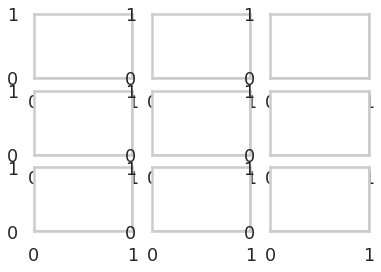

In [125]:
fig, axs = plt.subplots(ncols=3, nrows=3)


## Visualize data projection onto UCM, CMs

In [67]:
import io
import PIL

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

def _pairplot(df, var_list, rate_colors, npc, pca_lim, title_txt, ucm_space=None, cm_space=None):
    g = sns.PairGrid(df, x_vars=var_list, y_vars=var_list,
                     hue='Rate', 
                     palette=rate_colors, corner=True)
    g = g.map_lower(sns.scatterplot, s=15, hue_order=rate_list)
    g = g.map_diag(sns.kdeplot, hue_order=rate_list, common_norm=False)
    g = g.add_legend()
    g.fig.set_size_inches(7,7)
    g.fig.set_facecolor('white')
    g._legend.set_bbox_to_anchor((0.8, 0.8))
    # Iterate over axes
    for i in range(npc): # row
        for j in range(npc): # column
            # Draw bounding box
            if (g.axes[i,j] is not None):
                for _, spine in g.axes[i,j].spines.items():
                    spine.set_visible(True)
                    spine.set_color('gray')
            if (i != j) & (g.axes[i,j] is not None):
                # Set axis
                g.axes[i,j].set_xlim(pca_lim)
                g.axes[i,j].set_ylim(pca_lim)
                # Add UCM
                if ucm_space is not None:
                    g.axes[i,j].plot(ucm_space[:,j], ucm_space[:,i], '-', lw=1, color='blue', alpha=0.5)
                if cm_space is not None:
                    g.axes[i,j].plot_surface(cm_space[:,0], cm_space[:,1], cm_space[:,2], linewidth=0)
            # fix diag xlim, ylim
            if (i==j):
                g.axes[i,j].set_xlim(pca_lim)
                g.axes[i,j].set_xlabel('')
    g.fig.suptitle(title_txt, fontsize=25, y=1.07)
    return g

In [71]:
plot_again = False

In [72]:
which_init_pcs = 'N' # N, F, NF

which_time = 0.5
# which_model = 'all'
suffix = 'gpca_space'
# suffix = 'pca_space'
lim = [-50, 50]  # synthesis range
pca_lim = [-2.5,2.5]
rate_list = ['N', 'F']
custom_vowels = ['IY1', 'IH1', 'EH1', 'AE1']
nsample = 5
npc = len(gpca_col)
rate_colors = sns.color_palette('tab10', len(rate_list))
model_type = 'ANN' # ANN, LR

if plot_again:
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
#     for which_spkr in tqdm(['F01'], total=1):
        ucm_cm_dir = os.path.join(save_dir, which_spkr, 'ucm_cm')
        safe_rmdir(ucm_cm_dir)
        safe_mkdir(ucm_cm_dir)
        
        for which_vowel in custom_vowels:
            # For NF together
            model, init_pcs_NF, ucm_vec, cm_vec, ucm_space, median, pal, scaler, pca, _, _ = _prep_data_for_ucm(
                save_dir, model_type,  # dir, model
                which_spkr, which_vowel, 'NF', which_time,  # conditions
                lim=lim, nsample=nsample)
            # For N rate
            _, init_pcs_N, _, _, _, _, _, _, _, artics_N, formants_N = _prep_data_for_ucm(
                save_dir, model_type,  # dir, model
                which_spkr, which_vowel, 'N', which_time,  # conditions
                lim=lim, nsample=nsample)
            # For F rate
            _, init_pcs_F, _, _, _, _, _, _, _, artics_F, formants_F = _prep_data_for_ucm(
                save_dir, model_type,  # dir, model
                which_spkr, which_vowel, 'F', which_time,  # conditions
                lim=lim, nsample=nsample)
            
            if which_init_pcs == 'N':
                init_pcs = init_pcs_N
            elif which_init_pcs == 'F':
                init_pcs = init_pcs_F
            else:
                init_pcs = init_pcs_NF

            # Make sure to center artics by substracting init_pcs
            artics_raw = np.vstack([artics_F, artics_N])
            artics_centered = artics_raw - init_pcs
            #artics_centered = artics_raw - artics_N.mean(axis=0)

            NF = pd.DataFrame({col: artics_raw[:, i] for i, col in enumerate(gpca_col)})
            NF['Speaker'] = which_spkr
            NF['Vowel'] = which_vowel
            NF['Rate'] = ['F']*(artics_F.shape[0]) + ['N']*(artics_N.shape[0]) # this changed plotting zorder!!

            # Project data onto UCM and CM
            #### normalize ucm_vec length to 1
            ucm_vec = ucm_vec/np.linalg.norm(ucm_vec)
            # -- ucm, cm projection based on ucm and cm vector explicitly
            ucm_proj = artics_centered.dot(ucm_vec.dot(ucm_vec.T)) + init_pcs
            cm_proj = artics_centered.dot(cm_vec.dot(cm_vec.T)) + init_pcs
            # -- ucm, cm projection using subtraction
            #ucm_proj = artics_centered.dot(ucm_vec.dot(ucm_vec.T))
            #cm_proj = artics_centered - ucm_proj
            #ucm_proj += init_pcs
            #cm_proj += init_pcs
            
            NF_UCM = NF.copy()
            NF_CM = NF.copy()

            NF_UCM[gpca_col] = pd.DataFrame(ucm_proj)
            NF_CM[gpca_col] = pd.DataFrame(cm_proj)

            # Make CM ellipse
#             x, y, z = make_ellipsoid(cm_vec, r=lim[0]*0.5)
#             x += init_pcs[0]
#             y += init_pcs[1]
#             z += init_pcs[2]

            # Plot
            sns.set_theme(context='paper', style='whitegrid', 
                          rc={'legend.fontsize': 20, 
                              'legend.title_fontsize': 20,
                              'axes.labelsize': 20})
            # ----- Original data
            h = _pairplot(NF, gpca_col, rate_colors, npc, pca_lim, which_vowel, ucm_space)
            
            # ----- UCM projection
            g = _pairplot(NF_UCM, gpca_col, rate_colors, npc, pca_lim, 'UCM projection', ucm_space)

            # ----- CM projection
            f = _pairplot(NF_CM, gpca_col, rate_colors, npc, pca_lim, 'CM projection', ucm_space)

            # Combine
            img1 = fig2img(h)
            img2 = fig2img(g)
            img3 = fig2img(f)
            max_width = img1.size[0] * 3
            max_height = img1.size[1]
            new_img = PIL.Image.new('RGB', (max_width, max_height))
            x_offset = 0
            new_img.paste(img1, (0,0))
            new_img.paste(img2, (img1.size[0], 0))
            new_img.paste(img3, (img1.size[0]*2, 0))
            new_img.save(os.path.join(ucm_cm_dir, f'{which_spkr}_{which_vowel}_{suffix}.png'))

            # clean up
            img1.close()
            img2.close()
            img3.close()
            new_img.close()
            plt.close('all')
    print('Saved') # ~ 10 min
else:
    print('Skipping')

100%|██████████| 8/8 [03:11<00:00, 23.89s/it]

Saved


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

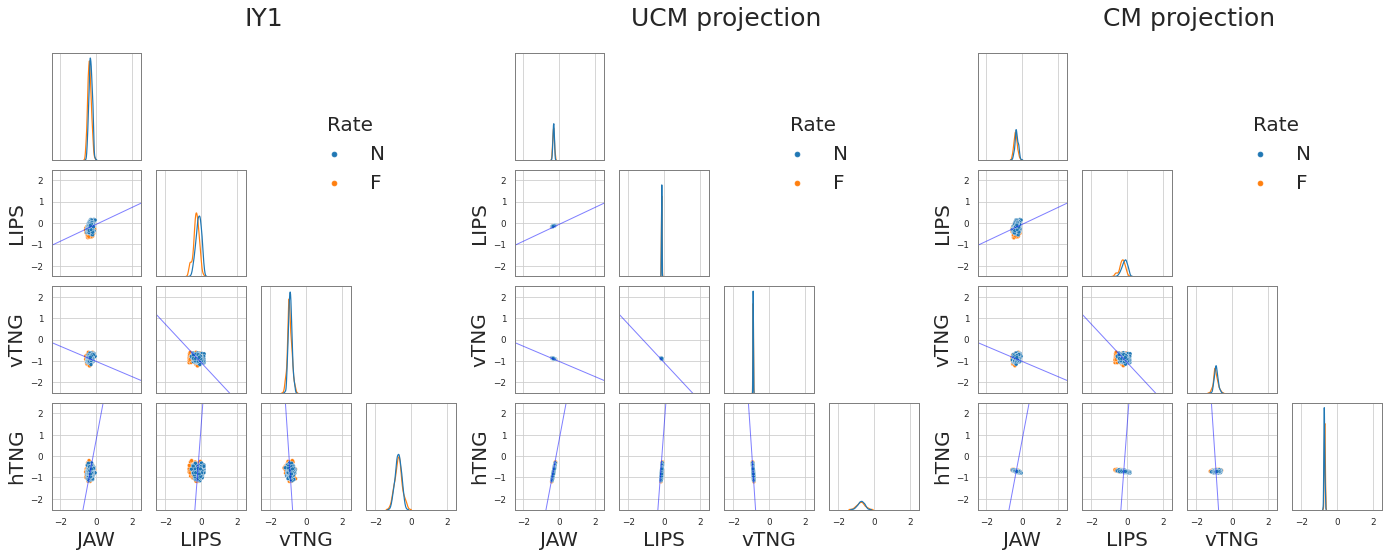

In [73]:
suffix = 'gpca_space'
def func2(which_spkr, which_vowel):
    return Image(filename=os.path.join(save_dir, which_spkr, 'ucm_cm', f'{which_spkr}_{which_vowel}_{suffix}.png'), width=1000)

spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
vowel_dropdown = widgets.Dropdown(options=custom_vowels, value=custom_vowels[0])
interact(func2, which_spkr=spkr_dropdown, which_vowel=vowel_dropdown);
func2('F01', 'IY1')